In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime

In [6]:
plt.style.use('seaborn-poster')

Модель ряда:

$$ 1.05\cos(\frac{2\pi}{24}n + \frac{3\pi}{4}) + 
                    0.82\cos(\frac{2\pi}{12} + \frac{\pi}{12}) + 
                    0.27\cos(\frac{2\pi}{8} - \frac{2\pi}{3}) + 
                    0.05\cos(\frac{2\pi}{6} - \frac{\pi}{3}) $$

In [30]:
def data_generator(ts_length = 400, 
                   random_seed = None, 
                   cp_prob = 1, 
                   is_multiplicative = False, 
                   is_trend = False, 
                   change_type = 'mean',
                   change_point = 352):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.10,ts_length)
    signal = signal_trend+signal_period+noise

    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     print(norm)
#     print(time_series)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)


def get_model_trend_X(time_series):
    ts_length = len(time_series)
#     X = np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
    X = np.hstack((
        np.array([1 for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
              ))
    return X

def get_model_sin_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]) #,
#         np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def get_model_sin_insight_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

def approximation_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_trend_X(time_series[0:window])
    left_right_X = get_model_trend_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def approximation_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_X(time_series[0:window])
    left_right_X = get_model_sin_X(time_series[0:int(window/2)])
#     right_X = get_model_sin_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm
    
    return(result)


def approximation_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_insight_X(time_series[0:window])
    left_right_X = get_model_sin_insight_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def prediction_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_trend_X(time_series[0:int(window/2)])
    right_X = get_model_trend_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_X(time_series[0:int(window/2)])
    right_X = get_model_sin_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    norm = np.mean(time_series[half_window:window])/np.mean(time_series[0:half_window])-1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    result.extend([abs(x/left_right_ts_mean[i-half_window]-1) for i, x in enumerate(left_right_ts_mean) if i >= half_window])
    
    return(result/norm)

def cp_detection(cost_values, threshold, cp_zone):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
                       if (cost_value >= threshold) and (ind >= cp_zone)]
#     list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
#                        if cost_value >= threshold]
    if len(list_of_indexes) == 0:
        return(None)
    else:
        return(list_of_indexes[0])   
#     return(list_of_indexes)

def any_to_list(inp):
    if isinstance(inp, list):
        return(inp)
    else:
        return([inp])

def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 

def cp_detection_modeling(approach = 'approximation_mean', 
                          iterations = 1000, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    for i in range(iterations):
        generated = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        for threshold in threshold_list:
            act[counter] = generated[1]
            pred[counter] = cp_detection(cp_1, threshold, change_point)
            tr[counter] = threshold
            counter += 1
        
    return([act, pred, tr])


def get_threshold_list(iterations = 1000, 
                       approach = 'approximation_mean', 
                       window = 48, 
                       cp_prob = 0.8, 
                       is_multiplicative = False, 
                       is_trend = False, 
                       change_type = 'mean',
                       change_point=352):
    detection_values = []
    for i in range(iterations):  
        generated = data_generator(cp_prob = cp_prob, 
                                   is_multiplicative = is_multiplicative, 
                                   is_trend = is_trend, 
                                   change_type = change_type,
                                   change_point = change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
#     threshold_max = np.percentile(detection_values, 95)
    threshold_max = max(detection_values)*1.2
#     threshold_max = float(round(threshold_max,6))
    threshold_max = float(threshold_max)
    threshold_list = list(np.arange(0, threshold_max, threshold_max/1000))
    return(threshold_list)

ROC AUC: 0.5060055049489333


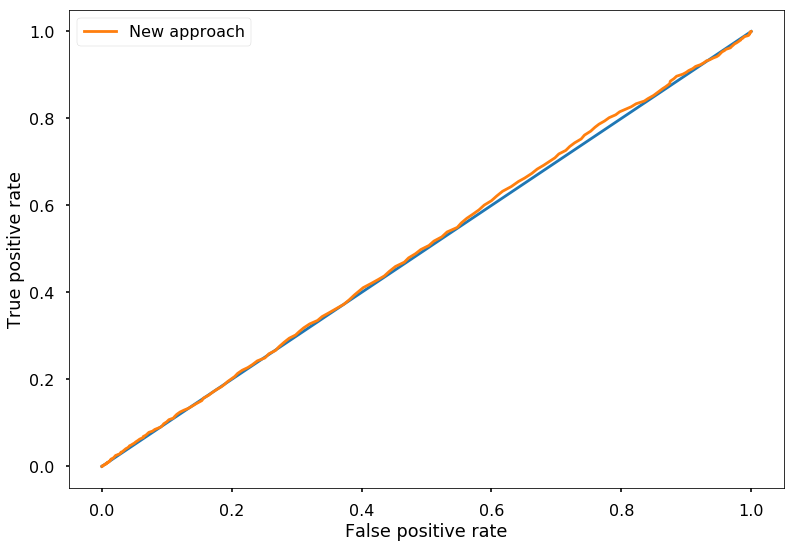

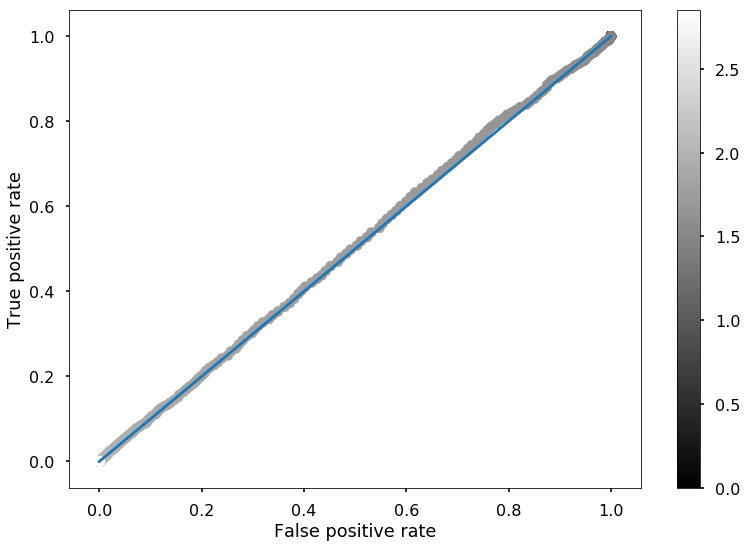

CPU times: user 5min 55s, sys: 3.64 s, total: 5min 59s
Wall time: 6min 3s


In [7]:
%%time

ITERATIONS = 10000
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 4
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

ROC AUC: 0.8300844704353476


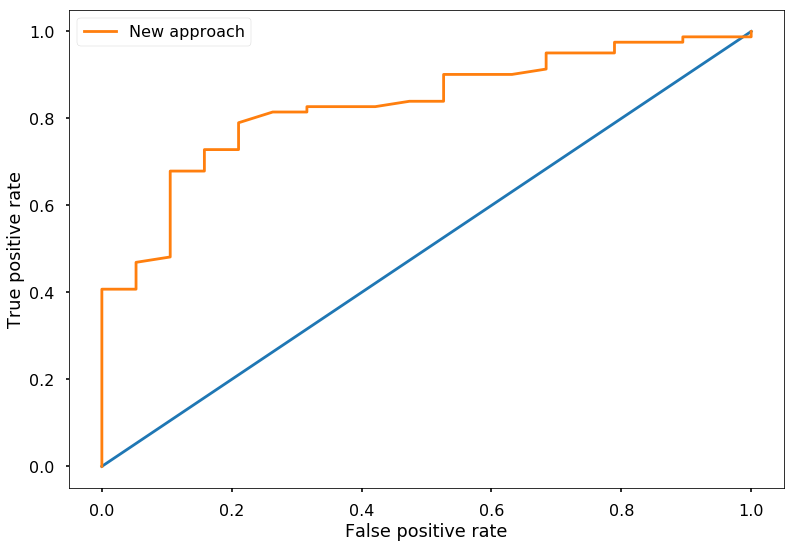

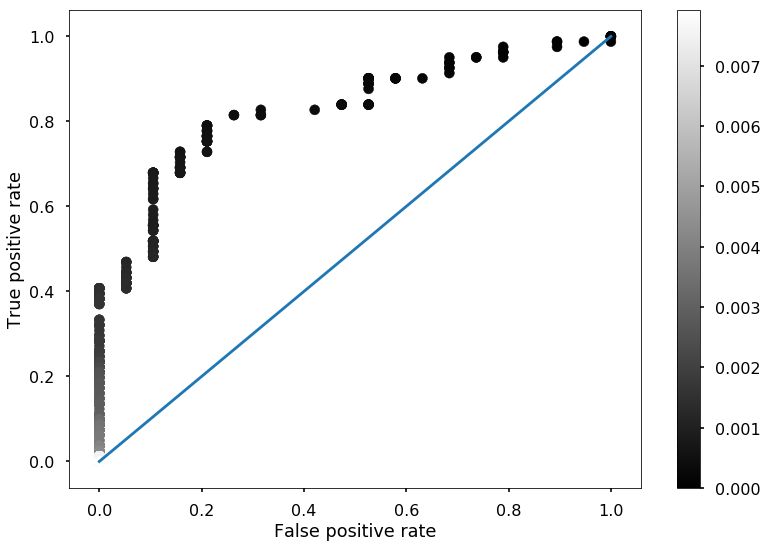

CPU times: user 18.8 s, sys: 54.8 ms, total: 18.8 s
Wall time: 18.8 s


In [22]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 48
IS_TREND = False
CHANGE_TYPE = 'mean'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [31]:
# WINDOWS = [72, 48, 24, 12, 6, 4, 2]
WINDOWS = [48, 24, 4, 2]
# WINDOWS = [48]
IS_TRENDS = [False, True]
CHANGE_TYPES = ['mean', 'trend', 'local']
APPROACHES = ['approximation_mean', 
              'prediction_mean', 
              'naive', 
              'approximation_trend',
              'approximation_sin_trend',
              'approximation_sin_insight_trend',
              'prediction_trend',
              'prediction_sin_trend',
              'prediction_sin_insight_trend']


In [33]:
len(WINDOWS)*len(IS_TRENDS)*len(CHANGE_TYPES)*len(APPROACHES)


216

In [32]:
%%time

ITERATIONS = 1
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
CHANGE_POINT = 396

df_results = pd.DataFrame()

for WINDOW in WINDOWS:
    print('Start at {}'.format(datetime.datetime.now()))
    for APPROACH in APPROACHES:
        print('Approach {}'.format(APPROACH))
        print('Loop at {}'.format(datetime.datetime.now()))
        for IS_TREND in IS_TRENDS:
            for CHANGE_TYPE in CHANGE_TYPES:
                threshold_list = get_threshold_list(iterations = ITERATIONS,
                                                    approach = APPROACH,
                                                    window = WINDOW, 
                                                    cp_prob = CP_PROB, 
                                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                                    is_trend = IS_TREND, 
                                                    change_type = CHANGE_TYPE,                         
                                                    change_point = CHANGE_POINT
                                                   )

                actual, predicted, thresholds = [], [], []
                actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                                              approach = APPROACH,
                                                              _window = WINDOW,
                                                              _cp_prob = CP_PROB,
                                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                                              threshold_list = threshold_list,
                                                              _is_trend = IS_TREND, 
                                                              _change_type = CHANGE_TYPE,
                                                              mode = 'change_end',
                                                              change_point = CHANGE_POINT
                                                                       )

                df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

                precision = []
                recall = []
                specificity = []
                average_delay = []
                # test = []
                for tr in threshold_list:
                    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                                          )
                    if sum(cp_result[0][:,1]) == 0:
                        precision.append(1)
                    else:
                        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))

                    if sum(cp_result[0][1,:]) == 0:
                        recall.append(1)
                    else:
                        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))

                    if sum(cp_result[0][0,:]) == 0:
                        specificity.append(1)
                    else:
                        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    

                    if cp_result[1]:
                        average_delay.append(np.mean(cp_result[1]))

                unspecificity = [1-x for x in specificity]

                unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

                df_results = df_results.append(pd.DataFrame(
                    {
                        'approach': APPROACH, 
                        'change_type': CHANGE_TYPE,
                        'is_trend': IS_TREND,
                        'window': WINDOW, 
                        'cp_prob': CP_PROB, 
                        'is_multiplicative': IS_MULTIPLICATIVE, 
                        'change_point': CHANGE_POINT,
                        'ROC AUC': np.trapz(recall_sorted, unspecificity_sorted)
                    }, index=[0]), ignore_index=True
                )


Start at 2019-04-06 09:40:56.286084
Approach approximation_mean
Loop at 2019-04-06 09:40:56.286246
End of loop 2019-04-06 09:41:04.584912
Approach prediction_mean
Loop at 2019-04-06 09:41:04.585030
End of loop 2019-04-06 09:41:12.611208
Approach naive
Loop at 2019-04-06 09:41:12.611318
End of loop 2019-04-06 09:41:20.535520
Approach approximation_trend
Loop at 2019-04-06 09:41:20.535644
End of loop 2019-04-06 09:41:29.345447
Approach approximation_sin_trend
Loop at 2019-04-06 09:41:29.345565
End of loop 2019-04-06 09:41:38.039166
Approach approximation_sin_insight_trend
Loop at 2019-04-06 09:41:38.039279
End of loop 2019-04-06 09:41:46.646943
Approach prediction_trend
Loop at 2019-04-06 09:41:46.647060
End of loop 2019-04-06 09:41:54.759217
Approach prediction_sin_trend
Loop at 2019-04-06 09:41:54.759323
End of loop 2019-04-06 09:42:02.909351
Approach prediction_sin_insight_trend
Loop at 2019-04-06 09:42:02.909490
End of loop 2019-04-06 09:42:11.136367
Approach approximation_mean
Loop 

End of loop 2019-04-06 09:52:27.784626
Approach prediction_sin_trend
Loop at 2019-04-06 09:52:27.784745
End of loop 2019-04-06 09:52:36.107475
Approach prediction_sin_insight_trend
Loop at 2019-04-06 09:52:36.107569
End of loop 2019-04-06 09:52:44.219775
Approach approximation_mean
Loop at 2019-04-06 09:52:44.219868
End of loop 2019-04-06 09:52:52.052345
Approach prediction_mean
Loop at 2019-04-06 09:52:52.052469
End of loop 2019-04-06 09:52:59.885345
Approach naive
Loop at 2019-04-06 09:52:59.885461
End of loop 2019-04-06 09:53:07.700574
Approach approximation_trend
Loop at 2019-04-06 09:53:07.700661
End of loop 2019-04-06 09:53:16.351185
Approach approximation_sin_trend
Loop at 2019-04-06 09:53:16.351276
End of loop 2019-04-06 09:53:25.068619
Approach approximation_sin_insight_trend
Loop at 2019-04-06 09:53:25.068709
End of loop 2019-04-06 09:53:35.096332
Approach prediction_trend
Loop at 2019-04-06 09:53:35.096570
End of loop 2019-04-06 09:53:44.281604
Approach prediction_sin_trend


End of loop 2019-04-06 10:03:48.969914
Approach approximation_sin_insight_trend
Loop at 2019-04-06 10:03:48.970023
End of loop 2019-04-06 10:03:57.919708
Approach prediction_trend
Loop at 2019-04-06 10:03:57.919827
End of loop 2019-04-06 10:04:06.122922
Approach prediction_sin_trend
Loop at 2019-04-06 10:04:06.123041
End of loop 2019-04-06 10:04:14.663564
Approach prediction_sin_insight_trend
Loop at 2019-04-06 10:04:14.663656
End of loop 2019-04-06 10:04:23.332670
Start at 2019-04-06 10:04:23.332769
Approach approximation_mean
Loop at 2019-04-06 10:04:23.332832
End of loop 2019-04-06 10:04:31.714642
Approach prediction_mean
Loop at 2019-04-06 10:04:31.714732
End of loop 2019-04-06 10:04:39.785308
Approach naive
Loop at 2019-04-06 10:04:39.785399
End of loop 2019-04-06 10:04:47.723468
Approach approximation_trend
Loop at 2019-04-06 10:04:47.723574
End of loop 2019-04-06 10:04:56.450968
Approach approximation_sin_trend
Loop at 2019-04-06 10:04:56.451057
End of loop 2019-04-06 10:05:05.7

In [34]:
df_results.head()

,ROC AUC,approach,change_point,change_type,cp_prob,is_multiplicative,is_trend,window
0,0.0,approximation_mean,396,mean,0.8,False,False,48
1,0.0,prediction_mean,396,mean,0.8,False,False,48
2,0.0,naive,396,mean,0.8,False,False,48
3,1.0,approximation_trend,396,mean,0.8,False,False,48
4,1.0,approximation_sin_trend,396,mean,0.8,False,False,48


In [38]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'window',
                          'change_point'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s